# Time Series Forecasting

A set of time-dependent data points is a time sequence. That means that a particular timestamp is allocated to each data point. Ideally, all data points are in chronological order and in time intervals of continuous time (e.g. every minute or everyday). The dilemma of time series forecasting analyzes trends to make predictions about the future in the past results.

##Importing Dependencies

As a first step, we need to import the necessary libraries. Matplotlib is frequently used in this notebook that will be written in Python programming language. When doing data analysis, it is beneficial for us to understand the data visually.

Secondly (optional) I have to mount my drive since I am working on Google colab. I added the data I'm working on to my drive folder.

In [ ]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import datetime
from io import StringIO

from google.colab import drive
from keras.callbacks import CSVLogger
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dataset

This data set is a csv file.Time series data usually comes in tabular format (e.g. csv files).

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Istanbul.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##Data Preprocessing

The information in the dataset is as follows: 
+ Temperature of Istanbul province 
+ Relative humidity
+ Precipitation total 
+ Snowfall amount
+ Cloud Cover Total 
+ Wind speed
+ Wind direction 


This information is given as hourly data between 2000-2020. Let's list this information.

Since the data provided for 2020 in the data set does not cover the whole year, it would be more accurate to analyze with the data before 2020. For this reason, we pull the data between the years ##2008-2019.Proje kapsamında 2008 2020 arasını vurgula

In [ ]:
df_Istanbul=pd.read_csv("/content/drive/MyDrive/Istanbul.csv", low_memory=False)
df_Istanbul.columns=df_Istanbul.loc[3].values
df_Istanbul=df_Istanbul.rename(columns={"variable":"timestamp"})
df_Istanbul=df_Istanbul.loc[9:]
df_Istanbul = df_Istanbul.rename(columns={"variable":"timestamp"})
df_Istanbul.info()
df_Istanbul[['date','time']] = pd.DataFrame(df_Istanbul.timestamp.str.split("T").tolist(), index= df_Istanbul.index)

df_Istanbul=df_Istanbul.drop(columns="timestamp")
df_Istanbul["date"]=pd.to_datetime(df_Istanbul["date"], format="%Y%m%d")

df_Istanbul[["Temperature","Relative Humidity","Precipitation Total",
         "Snowfall Amount","Cloud Cover Total","Wind Speed",
         "Wind Direction","time"]]=df_Istanbul[["Temperature","Relative Humidity","Precipitation Total",
         "Snowfall Amount","Cloud Cover Total","Wind Speed",
         "Wind Direction","time"]].astype(float)
df_Istanbul=df_Istanbul.loc[(df_Istanbul.date>="2008") & (df_Istanbul.date<"2020")]
df_Istanbul=df_Istanbul.reset_index(drop=True)
df_Istanbul.date[:12]
df_Istanbul.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176088 entries, 9 to 176096
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   timestamp            176088 non-null  object
 1   Temperature          111141 non-null  object
 2   Relative Humidity    111141 non-null  object
 3   Precipitation Total  111141 non-null  object
 4   Snowfall Amount      111141 non-null  object
 5   Cloud Cover Total    111141 non-null  object
 6   Wind Speed           111141 non-null  object
 7   Wind Direction       111141 non-null  object
dtypes: object(8)
memory usage: 10.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105192 entries, 0 to 105191
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Temperature          105189 non-null  float64       
 1   Relative Humidity    105189 non-null  float64       
 2   Pr

Since we deal for time sequences, the time-related features is the most important feature. We have the column date in this case, which defines a day hourly and uniquely.

Ideally, the material is already in chronological order, and in time series, the time stamps are equidistant. In our records, this is already the case: the time period is 24 hours in a day and the information is already in chronological order. But we need daily data so we have to do this phase of data processing to convert hourly data to daily data.

In [ ]:
df_Istanbul.dropna(axis=0, inplace=True)
df_Istanbul.tail()

,Temperature,Relative Humidity,Precipitation Total,Snowfall Amount,Cloud Cover Total,Wind Speed,Wind Direction,date,time
105187,5.339227,87.0,0.0,0.0,100.0,12.924952,347.12500,2019-12-31,1900.0
105188,5.019227,87.0,0.0,0.0,100.0,8.534353,332.35403,2019-12-31,2000.0
105189,4.809227,86.0,0.0,0.0,100.0,4.829907,296.56506,2019-12-31,2100.0
105190,4.739227,85.0,0.0,0.0,100.0,5.154415,245.22485,2019-12-31,2200.0
105191,4.829227,85.0,0.0,0.0,100.0,7.787991,213.69006,2019-12-31,2300.0


In [ ]:
df_Istanbul["date"] = pd.to_datetime(df_Istanbul["date"])
df_Istanbul["date"].tail()

105187   2019-12-31
105188   2019-12-31
105189   2019-12-31
105190   2019-12-31
105191   2019-12-31
Name: date, dtype: datetime64[ns]

We add the *year*, **week of the year**, week, year, month-day and time of the day features to the data in order to see the information to be used more easily when resampling data.

In [ ]:
df_Istanbul["Year"] =  df_Istanbul['date'].dt.strftime('%Y')
df_Istanbul["Year"] = df_Istanbul["Year"].astype(int)
print(df_Istanbul["Year"].unique())
df_Istanbul['Month-Day'] = df_Istanbul['date'].dt.strftime('%m-%d')
df_Istanbul['WeekoftheYear'] = df_Istanbul['date'].dt.strftime('%Y-%U')
df_Istanbul['Week'] = df_Istanbul['date'].dt.strftime('%U')
df_Istanbul['Year-Month-Day'] = df_Istanbul['date'].dt.strftime('%Y-%m-%d')
df_Istanbul['TimeoftheDay'] = df_Istanbul['date'].dt.strftime('%H:%M')

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


We take out the February 29 leap day, which is repeated every 4 years, in order to protect the unity of the data.

In [ ]:
#remove leap day
df_Istanbul = df_Istanbul[df_Istanbul["Month-Day"]!="02-29"]

The year we want to compare the minimum and maximum record-breaking temperatures is 2019.

In [ ]:
YOI = 2019 #Year of Interest

In [ ]:
df_Istanbul

,Temperature,Relative Humidity,Precipitation Total,Snowfall Amount,Cloud Cover Total,Wind Speed,Wind Direction,date,time,Year,Month-Day,WeekoftheYear,Week,Year-Month-Day,TimeoftheDay
3,0.269227,96.0,0.0,0.0,100.0,0.000000,180.000000,2008-01-01,300.0,2008,01-01,2008-00,00,2008-01-01,00:00
4,3.559227,79.0,0.0,0.0,40.0,13.493999,46.080917,2008-01-01,400.0,2008,01-01,2008-00,00,2008-01-01,00:00
5,2.639227,85.0,0.0,0.0,28.0,12.727922,44.999985,2008-01-01,500.0,2008,01-01,2008-00,00,2008-01-01,00:00
6,2.099227,86.0,0.0,0.0,29.0,13.246826,47.202590,2008-01-01,600.0,2008,01-01,2008-00,00,2008-01-01,00:00
7,1.529227,86.0,0.0,0.0,13.0,12.496718,48.503525,2008-01-01,700.0,2008,01-01,2008-00,00,2008-01-01,00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105187,5.339227,87.0,0.0,0.0,100.0,12.924952,347.125000,2019-12-31,1900.0,2019,12-31,2019-52,52,2019-12-31,00:00
105188,5.019227,87.0,0.0,0.0,100.0,8.534353,332.354030,2019-12-31,2000.0,2019,12-31,2019-52,52,2019-12-31,00:00
105189,4.809227,86.0,0.0,0.0,100.0,4.829907,296.565060,2019-12-31,2100.0,2019,12-31,2019-52,52,2019-12-31,00:00
105190,4.739227,85.0,0.0,0.0,100.0,5.154415,245.224850,2019-12-31,2200.0,2019,12-31,2019-52,52,2019-12-31,00:00


We extract the tables of minimum, maximum and mean temperatures.

In [ ]:
TMIN_dailly = df_Istanbul.groupby("Year-Month-Day")["Temperature"].min().reset_index()
TMIN_dailly.columns = ["Year-Month-Day", "Min. Temperature"]
TMIN_dailly.head()

,Year-Month-Day,Min. Temperature
0,2008-01-01,0.269227
1,2008-01-02,4.099227
2,2008-01-03,-1.990773
3,2008-01-04,-1.030773
4,2008-01-05,-0.870773


In [ ]:
TMAX_dailly = df_Istanbul.groupby("Year-Month-Day")["Temperature"].max().reset_index()
TMAX_dailly.columns = ["Year-Month-Day", "Max. Temperature"]
TMAX_dailly.head()

,Year-Month-Day,Max. Temperature
0,2008-01-01,10.529226
1,2008-01-02,8.989226
2,2008-01-03,2.509227
3,2008-01-04,4.839227
4,2008-01-05,1.799227


In [ ]:
TMEAN_dailly = df_Istanbul.groupby("Year-Month-Day")["Temperature"].mean().reset_index()
TMEAN_dailly.columns = ["Year-Month-Day", "Mean Temperature"]
TMEAN_dailly.head()

,Year-Month-Day,Mean Temperature
0,2008-01-01,5.377322
1,2008-01-02,5.997144
2,2008-01-03,0.459643
3,2008-01-04,2.160893
4,2008-01-05,0.609643


We add these extracted tables to our main data, df_Istanbul by converting hourly data to daily data.

In [ ]:
MIN_MAX_dailly = TMIN_dailly.merge(TMAX_dailly, left_on='Year-Month-Day', right_on='Year-Month-Day')
MIN_MAX_dailly.head()

,Year-Month-Day,Min. Temperature,Max. Temperature
0,2008-01-01,0.269227,10.529226
1,2008-01-02,4.099227,8.989226
2,2008-01-03,-1.990773,2.509227
3,2008-01-04,-1.030773,4.839227
4,2008-01-05,-0.870773,1.799227


In [ ]:
df_Istanbul = df_Istanbul.merge(MIN_MAX_dailly, left_on='Year-Month-Day', right_on='Year-Month-Day')
print(df_Istanbul.Year.unique())
df_Istanbul.tail()

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]


,Temperature,Relative Humidity,Precipitation Total,Snowfall Amount,Cloud Cover Total,Wind Speed,Wind Direction,date,time,Year,Month-Day,WeekoftheYear,Week,Year-Month-Day,TimeoftheDay,Min. Temperature,Max. Temperature
105112,5.339227,87.0,0.0,0.0,100.0,12.924952,347.12500,2019-12-31,1900.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227
105113,5.019227,87.0,0.0,0.0,100.0,8.534353,332.35403,2019-12-31,2000.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227
105114,4.809227,86.0,0.0,0.0,100.0,4.829907,296.56506,2019-12-31,2100.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227
105115,4.739227,85.0,0.0,0.0,100.0,5.154415,245.22485,2019-12-31,2200.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227
105116,4.829227,85.0,0.0,0.0,100.0,7.787991,213.69006,2019-12-31,2300.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227


In [ ]:
df_Istanbul = df_Istanbul.merge(TMEAN_dailly, left_on='Year-Month-Day', right_on='Year-Month-Day') #Sadece bir kere execute edilecek.

In [ ]:
df_Istanbul.tail()

,Temperature,Relative Humidity,Precipitation Total,Snowfall Amount,Cloud Cover Total,Wind Speed,Wind Direction,date,time,Year,Month-Day,WeekoftheYear,Week,Year-Month-Day,TimeoftheDay,Min. Temperature,Max. Temperature,Mean Temperature
105112,5.339227,87.0,0.0,0.0,100.0,12.924952,347.12500,2019-12-31,1900.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.39631
105113,5.019227,87.0,0.0,0.0,100.0,8.534353,332.35403,2019-12-31,2000.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.39631
105114,4.809227,86.0,0.0,0.0,100.0,4.829907,296.56506,2019-12-31,2100.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.39631
105115,4.739227,85.0,0.0,0.0,100.0,5.154415,245.22485,2019-12-31,2200.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.39631
105116,4.829227,85.0,0.0,0.0,100.0,7.787991,213.69006,2019-12-31,2300.0,2019,12-31,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.39631


###Duplicate and Missing Value Check

We check our data for self-repeating and missing data.

In [ ]:
print(df_Istanbul.isna().sum())
print(df_Istanbul[df_Istanbul.duplicated()])

Temperature            0
Relative Humidity      0
Precipitation Total    0
Snowfall Amount        0
Cloud Cover Total      0
Wind Speed             0
Wind Direction         0
date                   0
time                   0
Year                   0
Month-Day              0
WeekoftheYear          0
Week                   0
Year-Month-Day         0
TimeoftheDay           0
Min. Temperature       0
Max. Temperature       0
Mean Temperature       0
dtype: int64
Empty DataFrame
Columns: [Temperature, Relative Humidity, Precipitation Total, Snowfall Amount, Cloud Cover Total, Wind Speed, Wind Direction, date, time, Year, Month-Day, WeekoftheYear, Week, Year-Month-Day, TimeoftheDay, Min. Temperature, Max. Temperature, Mean Temperature]
Index: []


As you can see above, there are no blank entries or self-repeating lines in the data set.

##Min, Max and Mean Tempereture with Weekly Data

We converted the daily data to weekly data.

Although February 29 is issued, we see that there is 1 week remaining in our data. We're taking this week out.

In [ ]:
num_of_leapweeks = 1

In [ ]:
TMIN_others = df_Istanbul[df_Istanbul.Year != YOI].groupby("Week").agg({'Min. Temperature' : ['min']}).reset_index()
TMIN_others.columns = TMIN_others.columns.droplevel(1)
TMIN_others.head()
TMIN_others.size
TMIN_others.drop(TMIN_others.tail(num_of_leapweeks).index,inplace=True)
TMIN_others.size

106

In [ ]:
TMAX_others = df_Istanbul[df_Istanbul.Year != YOI].groupby("Week").agg({'Max. Temperature' : ['max']}).reset_index()
TMAX_others.columns = TMAX_others.columns.droplevel(1)
TMAX_others.head()
TMAX_others.size
TMAX_others.drop(TMAX_others.tail(num_of_leapweeks).index,inplace=True)
TMAX_others.size

106

In [ ]:
TMIN_YOI = df_Istanbul[df_Istanbul.Year == YOI].groupby("WeekoftheYear").agg({'Min. Temperature' : ['min']}).reset_index()
TMIN_YOI.columns = TMIN_YOI.columns.droplevel(1)
TMIN_YOI.head()
TMIN_YOI.size

106

In [ ]:
TMAX_YOI = df_Istanbul[df_Istanbul.Year == YOI].groupby("WeekoftheYear").agg({'Max. Temperature' : ['max']}).reset_index()
TMAX_YOI.columns = TMAX_YOI.columns.droplevel(1)
TMAX_YOI.head()
TMAX_YOI.size

106

And finally, we compare the years 2008-2018 with 2019 in order to see the weeks that broke the maximum and minimum temperature records.

In [ ]:
MIN_RECORD = TMIN_YOI[(TMIN_YOI['Min. Temperature'] < TMIN_others['Min. Temperature'])]
MAX_RECORD = TMAX_YOI[(TMAX_YOI['Max. Temperature'] > TMAX_others['Max. Temperature'])]
MIN_RECORD.head()

,WeekoftheYear,Min. Temperature
12,2019-12,1.009227
31,2019-31,16.509228
37,2019-37,11.009227
38,2019-38,9.789227


In [ ]:
MAX_RECORD.tail()

,WeekoftheYear,Max. Temperature
5,2019-05,19.569227
45,2019-45,28.439228


In [ ]:
TTemperature = df_Istanbul.groupby("WeekoftheYear")["Temperature"].mean().reset_index()
TTemperature.columns = ["WeekoftheYear", "Temperature"]
TTemperature.head()


,WeekoftheYear,Temperature
0,2008-00,2.857945
1,2008-01,3.569405
2,2008-02,6.610298
3,2008-03,5.430239
4,2008-04,4.358572


###Mean of Weekly Temperature of Istanbul: 2008-2019 Graph

We have visualized the average weekly temperature between 2008-2019 as shown in the table.

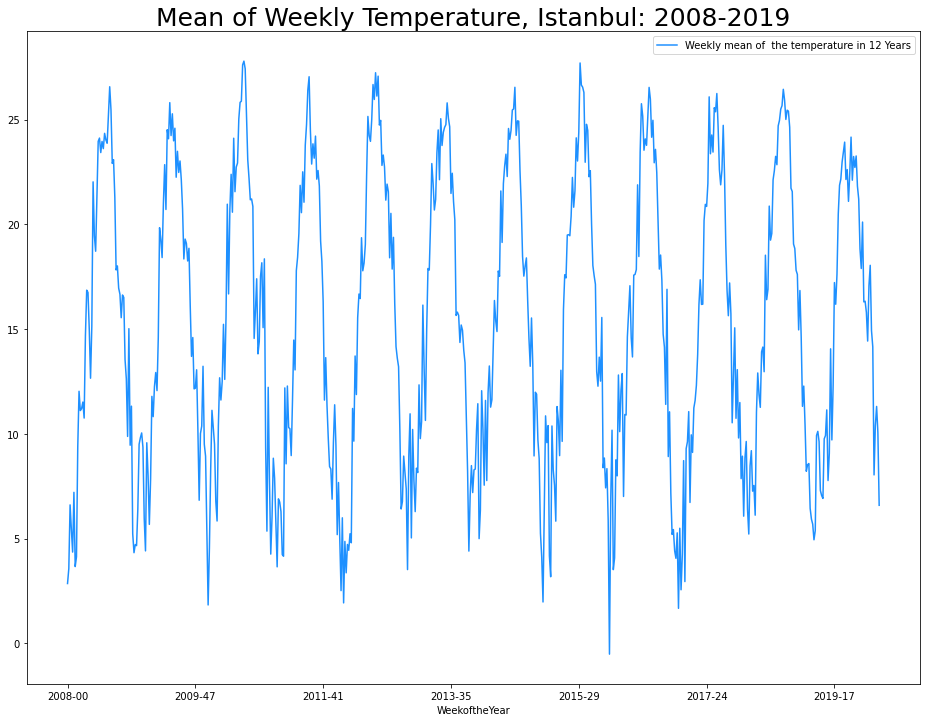

In [ ]:
lines = TTemperature.plot.line(x='WeekoftheYear', y='Temperature', figsize=(16, 12),color='dodgerblue',label='Weekly mean of  the temperature in 12 Years')
plt.title('Mean of Weekly Temperature, Istanbul: 2008-2019', fontsize=25)
plt.show()

The trend does not seem to be increasing for the last 10 years.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


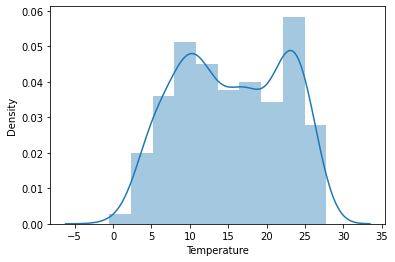

In [ ]:
sns.distplot(TTemperature['Temperature'])

The distribution density of temperature values between the years 2008-2019 is as shown in the graph.
If we interpret the temperature, it seems that there are two peaks. The first is probably the most common temperature in winter is between 7.5 and 11 Celsius, the second peak is between 24-27 Celsius in summer.

###Min and Max Weekly Temperature Comparison of Istanbul(with Record Points): 2008-2018 vs. 2019 Graph

The weeks that break the minimum and maximum records are as shown in the graph below. ## Yıl karşılaştırması yaptığımı vurgula bundan önceki stepleri neden yaptığını da önceden söyle.

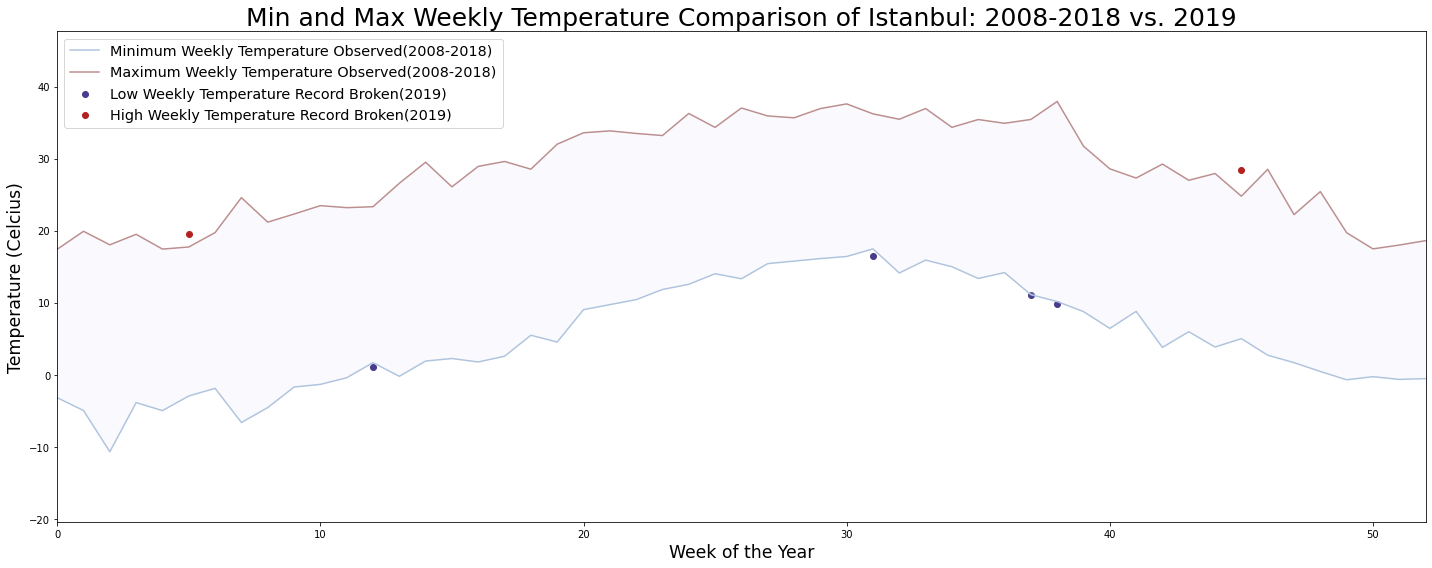

In [ ]:
plt.figure(111,(20,8))

plt.plot(TMIN_others['Min. Temperature'], color='lightsteelblue')
plt.plot(TMAX_others['Max. Temperature'], color='rosybrown')
plt.scatter(MIN_RECORD.index, MIN_RECORD['Min. Temperature'], color='darkslateblue')
plt.scatter(MAX_RECORD.index, MAX_RECORD['Max. Temperature'], color='firebrick')

# fill the area between high and low temperature line graphs

plt.gca().fill_between(range(len(TMIN_others['Min. Temperature'])), 
                       TMIN_others['Min. Temperature'], TMAX_others['Max. Temperature'], 
                       facecolor='lavender', 
                       alpha=0.2)
plt.title('Min and Max Weekly Temperature Comparison of Istanbul: 2008-2018 vs. 2019', fontsize=25)
plt.legend(['Minimum Weekly Temperature Observed(2008-2018)', 'Maximum Weekly Temperature Observed(2008-2018)',
            'Low Weekly Temperature Record Broken(2019)', 'High Weekly Temperature Record Broken(2019)'],
             loc='upper left', fontsize='x-large')
plt.xlabel('Week of the Year', fontsize='xx-large')
plt.ylabel('Temperature (Celcius)', fontsize= 'xx-large')
plt.margins(0.2)
plt.xlim(0, 52)
plt.tight_layout()
plt.savefig('TempComp_Istanbul.png')
plt.show()

In [ ]:
df_Istanbul.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,Temperature,Relative Humidity,Precipitation Total,Snowfall Amount,Cloud Cover Total,Wind Speed,Wind Direction,date,time,Year,Month-Day,WeekoftheYear,Week,Year-Month-Day,TimeoftheDay,Min. Temperature,Max. Temperature,Mean Temperature
0,0.269227,96.000000,0.000000,0.000000,100.000000,0.000000,180.000000,2008-01-01 00:00:00,300.000000,2008,01-01,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
1,3.559227,79.000000,0.000000,0.000000,40.000000,13.493999,46.080917,2008-01-01 00:00:00,400.000000,2008,01-01,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
2,2.639227,85.000000,0.000000,0.000000,28.000000,12.727922,44.999985,2008-01-01 00:00:00,500.000000,2008,01-01,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
3,2.099227,86.000000,0.000000,0.000000,29.000000,13.246826,47.202590,2008-01-01 00:00:00,600.000000,2008,01-01,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
4,1.529227,86.000000,0.000000,0.000000,13.000000,12.496718,48.503525,2008-01-01 00:00:00,700.000000,2008,01-01,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322


##Stationarity Check

Any time-series models presume that the underlying data is stationary, such as ARIMA. Stationarity defines the time series as having


*   constant mean (time-independent)
*   constant variance (time-independent) 
*   constant covariance (time-independent)





If a time series has a certain (stationary) behaviour over a given time interval, then the time series can be expected to behave the same at a later time.

Time series are not stationary with routine or seasonality. Trend implies that over time, the mean is not constant, and seasonality indicates that over time, the variation is not constant. ---> bunu değiştir serinin istatiksel ver

Three distinct methods can be used to search for stationarity:

1.   Visually: plot time series and search for seasonality or trends
2.   Basic Statistics: break time series and compare each partition's mean and variance
3. Statistical Test: Augmented Dickey Fuller test


###Visual Test

In [ ]:
rolling_window = 52

Since there are 52 weeks in a year, we equate the size of the rolling window to 52.

In [ ]:
print(TTemperature.columns)

Index(['WeekoftheYear', 'Temperature'], dtype='object')


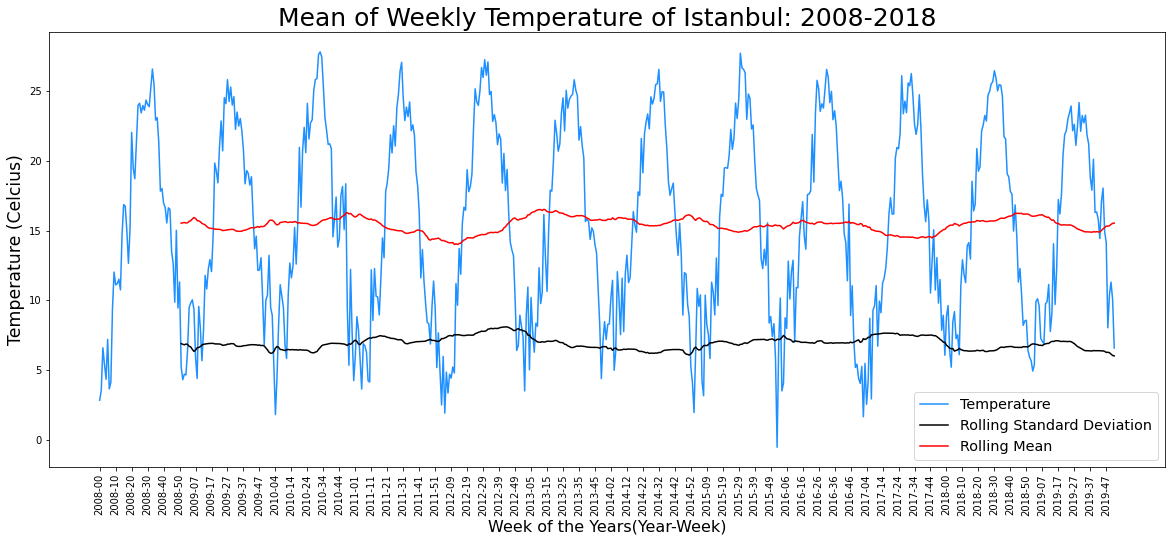

In [ ]:
plt.figure(112,(20,8))
#TTemperature.plot.line(x='Date', y='Temperature', figsize=(16, 12),color='dodgerblue',label='Change of  the temperature in 12 Years')
plt.plot(TTemperature.WeekoftheYear, TTemperature["Temperature"], color = "dodgerblue")
plt.plot(TTemperature.WeekoftheYear, TTemperature.Temperature.rolling(rolling_window).std(), color="black")
plt.plot(TTemperature.WeekoftheYear, TTemperature.Temperature.rolling(rolling_window).mean(),color='red')

plt.title('Mean of Weekly Temperature of Istanbul: 2008-2018', fontsize=25)
plt.legend(['Temperature', 'Rolling Standard Deviation', "Rolling Mean"], fontsize='x-large')
plt.xlabel('Week of the Year', fontsize='xx-large')
plt.xticks(rotation=45)
plt.MaxNLocator(10)
plt.ylabel('Temperature (Celcius)', fontsize= 'xx-large')
x=TTemperature.WeekoftheYear
plt.xlabel(xlabel="Week of the Years(Year-Week)", fontsize=16)
plt.xticks(np.arange(0, len(x)+1, 10), rotation='vertical')
#plt.margins(0.2)
#plt.xlim(0, 52)
#plt.tight_layout()
#plt.savefig('Staitonarity.png')
plt.show()

When we visualize the mean and standard deviation with a 52-week rolling window, both mean and standard deviation seem to oscillate slightly. We further investigate whether this variation in  mean and variance is statistically meaningful or not.

###Local Test

In [ ]:
num_partitions = 2
partition_length = int(len(TTemperature) / num_partitions)

partition1_mean = TTemperature.head(partition_length).mean()
partition1_var = TTemperature.head(partition_length).var()
partition2_mean = TTemperature.tail(partition_length).mean()
partition2_var = TTemperature.tail(partition_length).var()

In [ ]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']


In [ ]:
stationarity_test

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Temperature,15.365298,15.425158,49.328802,45.542827


We noticed a little difference when we split the time series into two partitions and compared the mean and variance of both parts. Surely, because we do not run a hyphothesis test yet, we do not know whether the difference is meaningful or not.

###ADF(Augmented Dickey-Fuller) Test

The Augmented Dickey-Fuller (ADF) test is called a unit root test, a form of statistical test. A reason for non-stationarity is unit roots.

*   Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).


*   Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary



There are two ways to rejects the null hypothesis:

1.   **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
2.   **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

The null hypothesis, but then
, may be denied if the test figures are smaller than the critical value.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(TTemperature.Temperature.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']

In [ ]:
TTemperature.size

1272

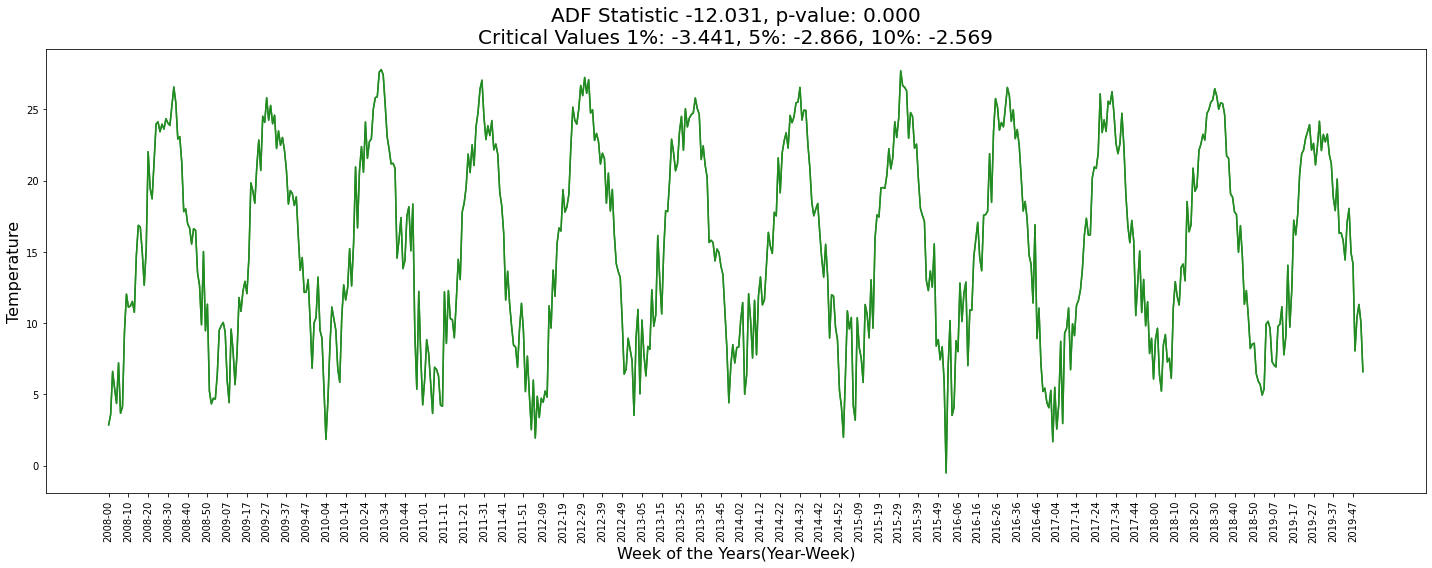

In [ ]:
def visualize_adfuller_results(series, title):
    plt.figure(112,(20,8))
    result = adfuller(series, autolag='AIC')
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'
    sns.lineplot(x=TTemperature.WeekoftheYear, y=series, color=linecolor)
    sns.lineplot(x=TTemperature.WeekoftheYear, y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f} \nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=20)
    plt.ylabel(ylabel=title, fontsize=16)
    x=TTemperature.WeekoftheYear
    plt.xlabel(xlabel="Week of the Years(Year-Week)", fontsize=16)
    plt.xticks(np.arange(0, len(x)+1, 10), rotation='vertical')

visualize_adfuller_results(TTemperature.Temperature.values, 'Temperature')

plt.tight_layout()
plt.show()

In [ ]:
df_Istanbul = df_Istanbul.drop(['Relative Humidity', 'Precipitation Total', 'Snowfall Amount', 'Cloud Cover Total', 'Wind Speed', 'Wind Direction', 'time','Month-Day'], axis=1)

In [ ]:
df_Istanbul.drop_duplicates().reset_index()

,index,Temperature,date,Year,WeekoftheYear,Week,Year-Month-Day,TimeoftheDay,Min. Temperature,Max. Temperature,Mean Temperature
0,0,0.269227,2008-01-01,2008,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
1,1,3.559227,2008-01-01,2008,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
2,2,2.639227,2008-01-01,2008,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
3,3,2.099227,2008-01-01,2008,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
4,4,1.529227,2008-01-01,2008,2008-00,00,2008-01-01,00:00,0.269227,10.529226,5.377322
...,...,...,...,...,...,...,...,...,...,...,...
103044,105112,5.339227,2019-12-31,2019,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.396310
103045,105113,5.019227,2019-12-31,2019,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.396310
103046,105114,4.809227,2019-12-31,2019,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.396310
103047,105115,4.739227,2019-12-31,2019,2019-52,52,2019-12-31,00:00,4.739227,7.179227,6.396310


## Feature Engineering

In [ ]:
resampled_df = df_Istanbul[['date','Temperature']].resample('7D', on='date').mean().reset_index(drop=False)
df_Istanbul = resampled_df

### Tranformed Features

In [ ]:
df_Istanbul['Year'] = pd.DatetimeIndex(df_Istanbul['date']).year
df_Istanbul['Month'] = pd.DatetimeIndex(df_Istanbul['date']).month
df_Istanbul['Day'] = pd.DatetimeIndex(df_Istanbul['date']).day
df_Istanbul['DayoftheYear'] = pd.DatetimeIndex(df_Istanbul['date']).dayofyear
df_Istanbul['WeekoftheYear'] = pd.DatetimeIndex(df_Istanbul['date']).weekofyear
df_Istanbul['Quarter'] = pd.DatetimeIndex(df_Istanbul['date']).quarter
#df_Istanbul['Season'] = df_Istanbul.Month%12 // 3 + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


In [ ]:
df_Istanbul[['date', 'Year', 'Month', 'Day', 'DayoftheYear', 'WeekoftheYear', 'Quarter']].head()

,date,Year,Month,Day,DayoftheYear,WeekoftheYear,Quarter
0,2008-01-01,2008,1,1,1,1,1
1,2008-01-08,2008,1,8,8,2,1
2,2008-01-15,2008,1,15,15,3,1
3,2008-01-22,2008,1,22,22,4,1
4,2008-01-29,2008,1,29,29,5,1


In [ ]:
df_Istanbul

,date,Temperature,Year,Month,Day,DayoftheYear,WeekoftheYear,Quarter
0,2008-01-01,3.197469,2008,1,1,1,1,1
1,2008-01-08,3.926786,2008,1,8,8,2,1
2,2008-01-15,6.724286,2008,1,15,15,3,1
3,2008-01-22,5.357739,2008,1,22,22,4,1
4,2008-01-29,5.579822,2008,1,29,29,5,1
...,...,...,...,...,...,...,...,...
622,2019-12-03,8.060179,2019,12,3,337,49,4
623,2019-12-10,10.889405,2019,12,10,344,50,4
624,2019-12-17,12.297798,2019,12,17,351,51,4
625,2019-12-24,7.939405,2019,12,24,358,52,4


###Encoding Cyclical Features

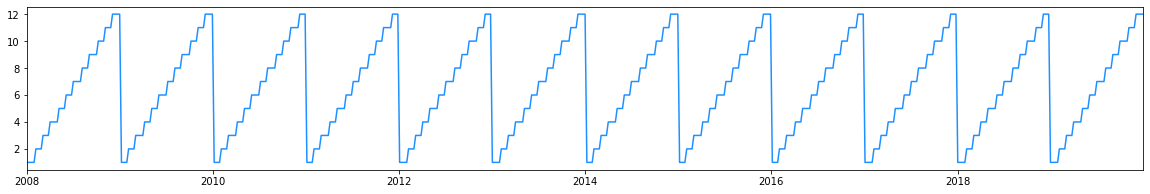

In [ ]:
plt.figure(114,(20,3))
plt.plot(df_Istanbul.date, df_Istanbul.Month, color='dodgerblue')
plt.xlim([datetime.date(2008, 1, 1), datetime.date(2019, 12, 30)])
plt.show()
#Title eklenecek x ve y axis için ayrı grafiğin ismi için ayrı

In [ ]:
month_in_year = 12
df_Istanbul['month_sin'] = np.sin(2*np.pi*df_Istanbul.Month/month_in_year)
df_Istanbul['month_cos'] = np.cos(2*np.pi*df_Istanbul.Month/month_in_year)

days_in_month = 30
df_Istanbul['day_sin'] = np.sin(2*np.pi*df_Istanbul.Day/days_in_month)
df_Istanbul['day_cos'] = np.cos(2*np.pi*df_Istanbul.Day/days_in_month)

days_in_year = 365
df_Istanbul['day_of_year_sin'] = np.sin(2*np.pi*df_Istanbul.DayoftheYear/days_in_year)
df_Istanbul['day_of_year_cos'] = np.cos(2*np.pi*df_Istanbul.DayoftheYear/days_in_year)

weeks_in_year = 52.1429
df_Istanbul['week_of_year_sin'] = np.sin(2*np.pi*df_Istanbul.WeekoftheYear/weeks_in_year)
df_Istanbul['week_of_year_cos'] = np.cos(2*np.pi*df_Istanbul.WeekoftheYear/weeks_in_year)

quarters_in_year = 4
df_Istanbul['quarter_sin'] = np.sin(2*np.pi*df_Istanbul.Quarter/quarters_in_year)
df_Istanbul['quarter_cos'] = np.cos(2*np.pi*df_Istanbul.Quarter/quarters_in_year)

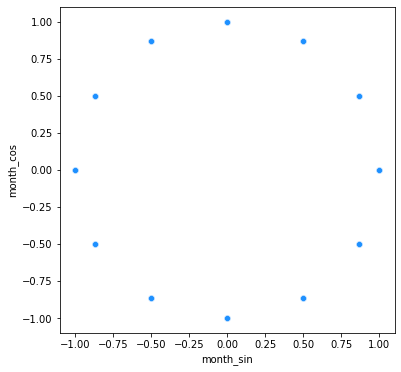

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_Istanbul.month_sin, y=df_Istanbul.month_cos, color='dodgerblue')
plt.show()

###Decomposition

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.


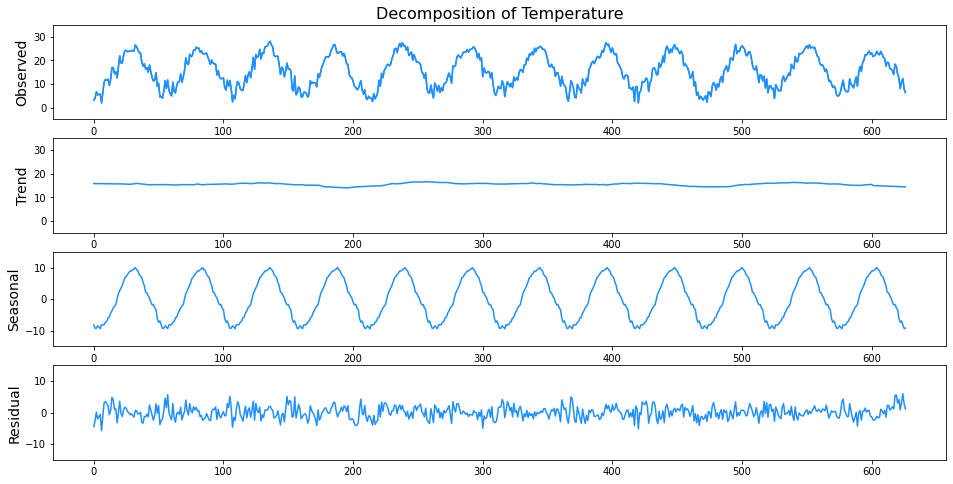

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#decompose_col =  ['Temperature']

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 8))

decomp = seasonal_decompose(df_Istanbul["Temperature"], freq=52, model='additive', extrapolate_trend='freq')
df_Istanbul["Temperature_trend"] = decomp.trend
df_Istanbul["Temperature_seasonal"] = decomp.seasonal

res = seasonal_decompose(df_Istanbul.Temperature, freq=52, model='additive', extrapolate_trend='freq')
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_title('Decomposition of Temperature', fontsize=16)
res.observed.plot(ax=ax[0], legend=False, color='dodgerblue')
ax[0].set_ylabel('Observed', fontsize=14)
ax[0].set_ylim([-5, 35])

res.trend.plot(ax=ax[1], legend=False, color='dodgerblue')
ax[1].set_ylabel('Trend', fontsize=14)
ax[1].set_ylim([-5, 35])

res.seasonal.plot(ax=ax[2], legend=False, color='dodgerblue')
ax[2].set_ylabel('Seasonal', fontsize=14)
ax[2].set_ylim([-15, 15])

res.resid.plot(ax=ax[3], legend=False, color='dodgerblue')
ax[3].set_ylabel('Residual', fontsize=14)
ax[3].set_ylim([-15, 15])
plt.show()

In [ ]:
'''from pandas.plotting import autocorrelation_plot
res.resid
plt.figure(112,(50,50))
plot_acf(res.resid,lags=100)
plt.show()'''

'from pandas.plotting import autocorrelation_plot\nres.resid\nplt.figure(112,(50,50))\nplot_acf(res.resid,lags=100)\nplt.show()'

In [ ]:
df_Istanbul[['Temperature', 'Temperature_trend', 'Temperature_seasonal']].head()\
.style.set_properties(subset=['Temperature_trend', 'Temperature_seasonal'], **{'background-color': 'dodgerblue'})

,Temperature,Temperature_trend,Temperature_seasonal
0,3.197469,15.882752,-8.198981
1,3.926786,15.874872,-9.316454
2,6.724286,15.866992,-9.237915
3,5.357739,15.859112,-8.478073
4,5.579822,15.851232,-8.866193


###Lag

In [ ]:
weeks_in_month = 4

df_Istanbul['Temperature_seasonal_shift_r_2M'] = df_Istanbul.Temperature_seasonal.shift(-2*weeks_in_month)
df_Istanbul['Temperature_seasonal_shift_r_1M'] = df_Istanbul.Temperature_seasonal.shift(-1*weeks_in_month)
df_Istanbul['Temperature_seasonal_shift_1M'] = df_Istanbul.Temperature_seasonal.shift(1*weeks_in_month)
df_Istanbul['Temperature_seasonal_shift_2M'] = df_Istanbul.Temperature_seasonal.shift(2*weeks_in_month)
df_Istanbul['Temperature_seasonal_shift_3M'] = df_Istanbul.Temperature_seasonal.shift(3*weeks_in_month)

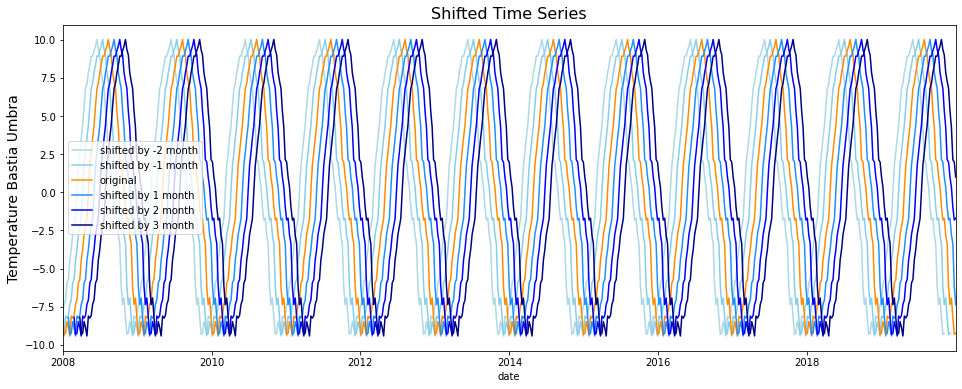

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal_shift_r_2M, label='shifted by -2 month', ax=ax, color='lightblue')
sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal_shift_r_1M, label='shifted by -1 month', ax=ax, color='skyblue')

sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal, label='original', ax=ax, color='darkorange')

sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal_shift_1M, label='shifted by 1 month', ax=ax, color='dodgerblue')
sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal_shift_2M, label='shifted by 2 month', ax=ax, color='blue')
sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal_shift_3M, label='shifted by 3 month', ax=ax, color='navy')

ax.set_title('Shifted Time Series', fontsize=16)

ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2019, 12, 30)])
ax.set_ylabel(ylabel='Temperature Bastia Umbra', fontsize=14)

plt.show()

###Exploratory Data Analysis

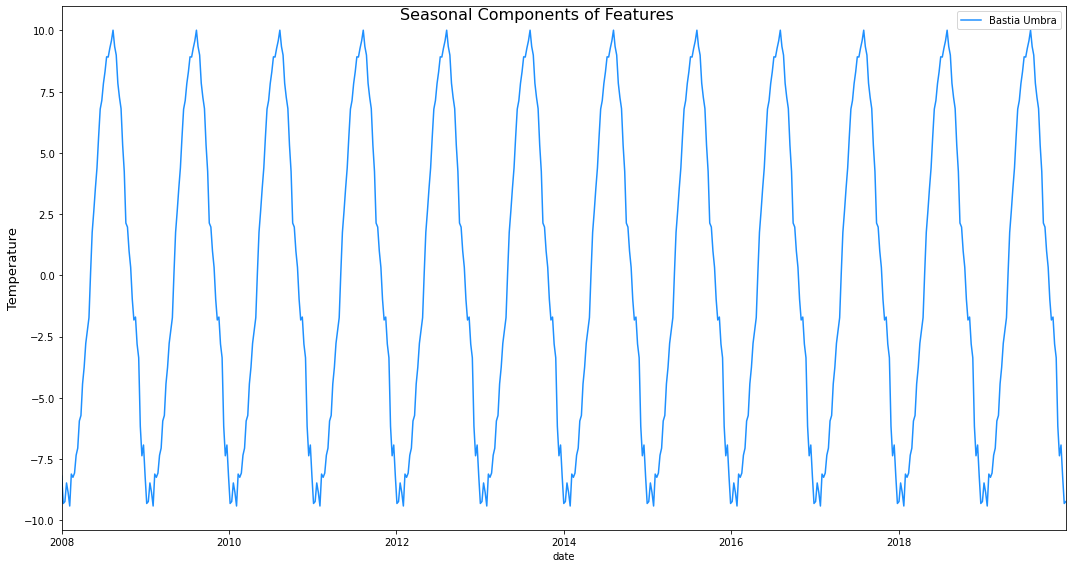

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))
f.suptitle('Seasonal Components of Features', fontsize=16)

sns.lineplot(x=df_Istanbul.date, y=df_Istanbul.Temperature_seasonal, ax=ax, color='dodgerblue', label='Bastia Umbra')
ax.set_ylabel(ylabel='Temperature', fontsize=13)

ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2019, 12, 30)])
plt.tight_layout()
plt.show()

In [ ]:
df_Istanbul

,date,Temperature,Year,Month,Day,DayoftheYear,WeekoftheYear,Quarter,month_sin,month_cos,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,Temperature_trend,Temperature_seasonal,Temperature_seasonal_shift_r_2M,Temperature_seasonal_shift_r_1M,Temperature_seasonal_shift_1M,Temperature_seasonal_shift_2M,Temperature_seasonal_shift_3M
0,2008-01-01,3.197469,2008,1,1,1,1,1,5.000000e-01,0.866025,2.079117e-01,0.978148,1.721336e-02,0.999852,0.120208,0.992749,1.000000e+00,6.123234e-17,15.882752,-8.198981,-8.075292,-8.866193,NaN,NaN,NaN
1,2008-01-08,3.926786,2008,1,8,8,2,1,5.000000e-01,0.866025,9.945219e-01,-0.104528,1.372788e-01,0.990532,0.238673,0.971100,1.000000e+00,6.123234e-17,15.874872,-9.316454,-7.345796,-9.419959,NaN,NaN,NaN
2,2008-01-15,6.724286,2008,1,15,15,3,1,5.000000e-01,0.866025,5.665539e-16,-1.000000,2.553533e-01,0.966848,0.353676,0.935368,1.000000e+00,6.123234e-17,15.866992,-9.237915,-7.056216,-8.115087,NaN,NaN,NaN
3,2008-01-22,5.357739,2008,1,22,22,4,1,5.000000e-01,0.866025,-9.945219e-01,-0.104528,3.697245e-01,0.929141,0.463550,0.886071,1.000000e+00,6.123234e-17,15.859112,-8.478073,-5.946039,-8.247676,NaN,NaN,NaN
4,2008-01-29,5.579822,2008,1,29,29,5,1,5.000000e-01,0.866025,-2.079117e-01,0.978148,4.787338e-01,0.877960,0.566701,0.823923,1.000000e+00,6.123234e-17,15.851232,-8.866193,-5.722420,-8.075292,-8.198981,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,2019-12-03,8.060179,2019,12,3,337,49,4,-2.449294e-16,1.000000,5.877853e-01,0.809017,-4.635503e-01,0.886071,-0.369729,0.929140,-2.449294e-16,1.000000e+00,14.570369,-7.368258,NaN,-9.237915,-1.703009,0.993771,5.319716
623,2019-12-10,10.889405,2019,12,10,344,50,4,-2.449294e-16,1.000000,8.660254e-01,-0.500000,-3.536761e-01,0.935368,-0.255358,0.966847,-2.449294e-16,1.000000e+00,14.548675,-6.928814,NaN,NaN,-2.806412,0.326123,4.241884
624,2019-12-17,12.297798,2019,12,17,351,51,4,-2.449294e-16,1.000000,-4.067366e-01,-0.913545,-2.386728e-01,0.971100,-0.137284,0.990532,-2.449294e-16,1.000000e+00,14.526981,-8.198981,NaN,NaN,-3.364544,-0.974016,2.135646
625,2019-12-24,7.939405,2019,12,24,358,52,4,-2.449294e-16,1.000000,-9.510565e-01,0.309017,-1.202080e-01,0.992749,-0.017219,0.999852,-2.449294e-16,1.000000e+00,14.505287,-9.316454,NaN,NaN,-6.161686,-1.822409,1.972045


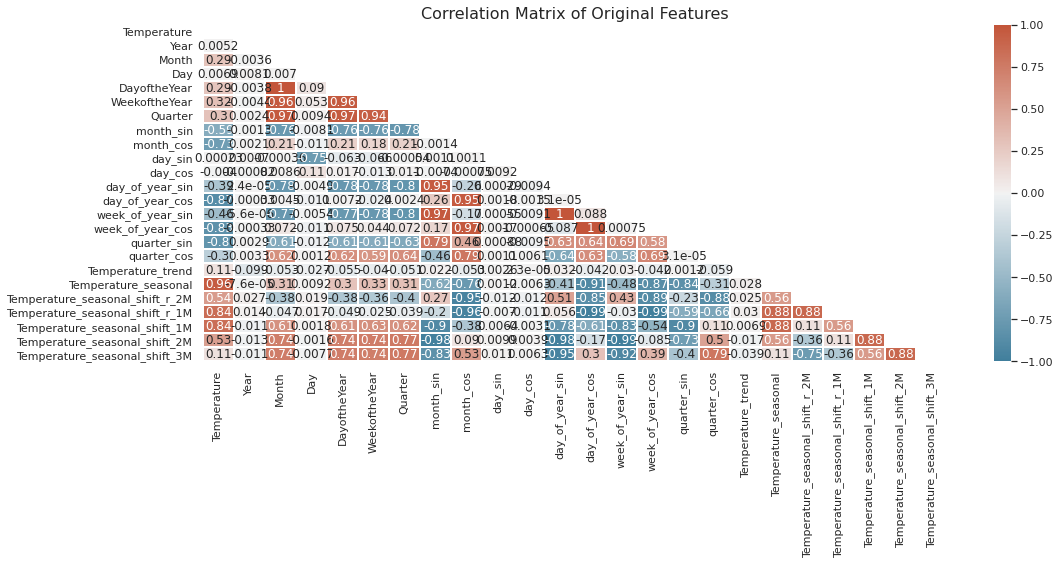

In [ ]:
sns.set_theme(style="white")
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
features = df_Istanbul.columns
features = features.drop("date")
corrmat_all = df_Istanbul[features].corr()
mask = np.triu(np.ones_like(corrmat_all, dtype=bool))


cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrmat_all, mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=1, linewidths=.5, ax=ax)
ax.set_title('Correlation Matrix of Original Features', fontsize=16)

plt.tight_layout()
plt.show()

The cut-off for the temperature column was taken as 0.70 correlation.
+ Temperature_seasonal = 0,96
+ Temperature_seasonal_shift_1M = 0,84
+ Temperature_seasonal_shift_r_1M = 0,84
+ weak_of_the_year_cos = 0,83
+ day_of_year_cos = 0,82
+ quarter_sin = 0,80
+ month_cos = 0,73

Now I will look at the correlation between these seven columns in order to make a more accurate prediction. Otherwise, columns that are very similar to each other can be taken twice. In this case, the forecast model will estimate, for example, by attaching more importance to the seasonality situation. The significance of the predictions will be in danger.

First, i will look at the Temperature_seasonal column, which is of the highest importance.
+ month_cos = 0,76
+ day_of_year_cos = 0,91
+ week_of_year_cos = 0,84
+ quarter_sin = 0,84

Since these columns are above the corelation cut-off, I remove it from the prediction model.

In [ ]:
features = df_Istanbul.columns
features = features.drop("date")

###Autocorrelation Analysis

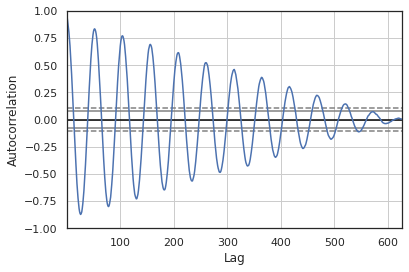

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_Istanbul.Temperature)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


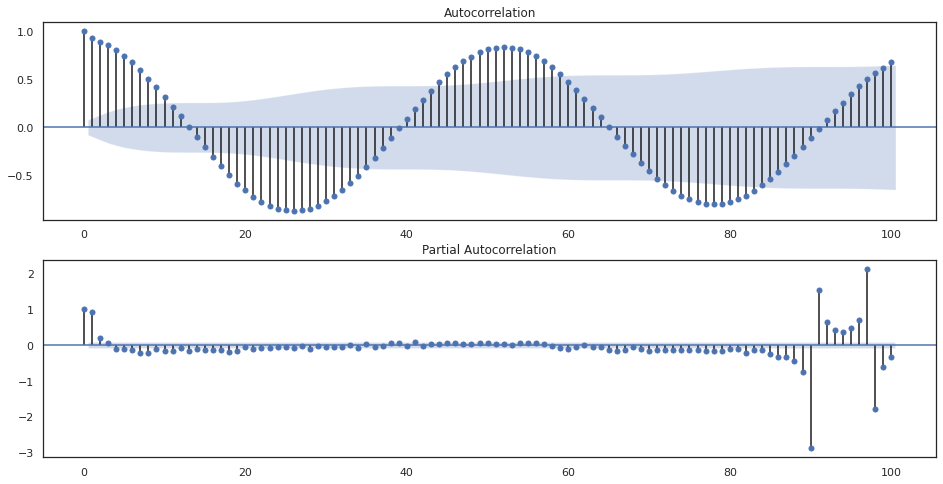

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df_Istanbul.Temperature,lags=100, ax=ax[0])
plot_pacf(df_Istanbul.Temperature,lags=100, ax=ax[1])
plt.show()

Autocorrelation grafiğinde düzenli bir düşüş auto regresive bir process'in göstergesi olduğuna göre bizim datamız oto regresive bir process göstermiyor diyebiliriz. Partial uygulamak daha doğru olur mu?

???For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots, meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend.???

##Cross Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df_Istanbul.date
y = df_Istanbul.Temperature

folds = TimeSeriesSplit(n_splits=N_SPLITS)

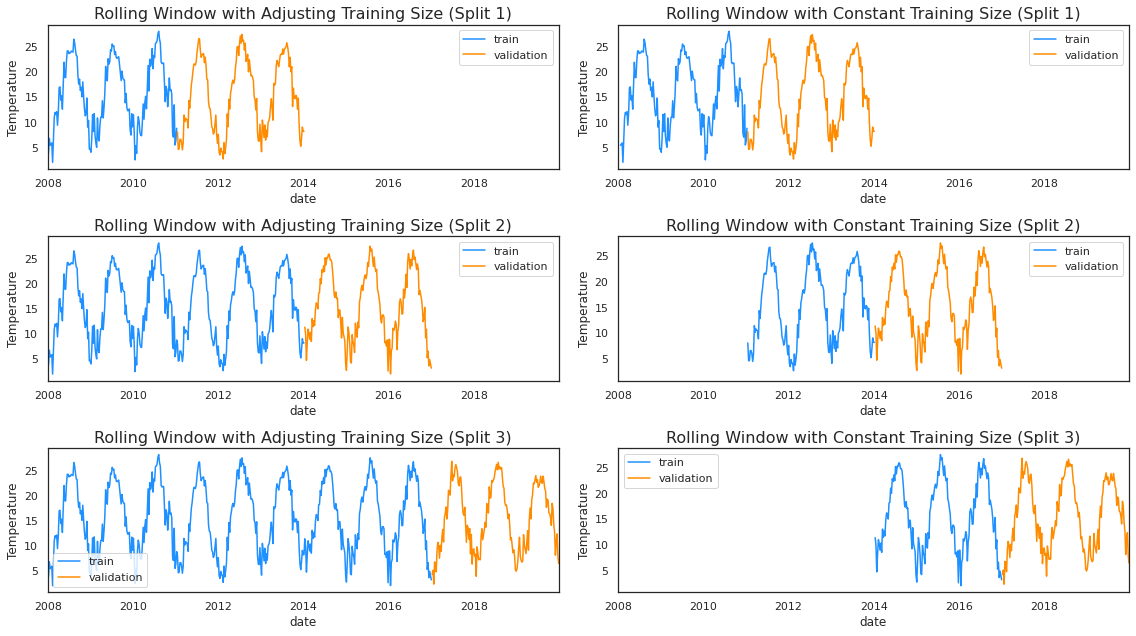

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([datetime.date(2008, 1, 1), datetime.date(2019, 12, 30)])
    ax[i, 1].set_xlim([datetime.date(2008, 1, 1), datetime.date(2019, 12, 30)])
plt.tight_layout()
plt.show()

##Splitting Test and Train Data 

In [ ]:
df_Istanbul.size

15675

In [ ]:
X_train.head()

0   2008-01-01
1   2008-01-08
2   2008-01-15
3   2008-01-22
4   2008-01-29
Name: date, dtype: datetime64[ns]

In [ ]:
y_train.head()

0    3.197469
1    3.926786
2    6.724286
3    5.357739
4    5.579822
Name: Temperature, dtype: float64

+ p = lag order
+ d = degree of differencing (burada 0 alınacak)
+ q = order of moving average

In [ ]:
test=df_Istanbul[df_Istanbul['Year'] == YOI]

In [ ]:
test.head()

,date,Temperature,Year,Month,Day,DayoftheYear,WeekoftheYear,Quarter,month_sin,month_cos,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,Temperature_trend,Temperature_seasonal,Temperature_seasonal_shift_r_2M,Temperature_seasonal_shift_r_1M,Temperature_seasonal_shift_1M,Temperature_seasonal_shift_2M,Temperature_seasonal_shift_3M
574,2019-01-01,4.850953,2019,1,1,1,1,1,0.5,0.866025,2.079117e-01,0.978148,0.017213,0.999852,0.120208,0.992749,1.0,6.123234e-17,15.717187,-9.237915,-7.056216,-8.115087,-7.368258,-1.703009,0.993771
575,2019-01-08,5.366905,2019,1,8,8,2,1,0.5,0.866025,9.945219e-01,-0.104528,0.137279,0.990532,0.238673,0.971100,1.0,6.123234e-17,15.666151,-8.478073,-5.946039,-8.247676,-6.928814,-2.806412,0.326123
576,2019-01-15,6.898215,2019,1,15,15,3,1,0.5,0.866025,5.665539e-16,-1.000000,0.255353,0.966848,0.353676,0.935368,1.0,6.123234e-17,15.588316,-8.866193,-5.722420,-8.075292,-8.198981,-3.364544,-0.974016
577,2019-01-22,9.547262,2019,1,22,22,4,1,0.5,0.866025,-9.945219e-01,-0.104528,0.369725,0.929141,0.463550,0.886071,1.0,6.123234e-17,15.522950,-9.419959,-4.433071,-7.345796,-9.316454,-6.161686,-1.822409
578,2019-01-29,11.634703,2019,1,29,29,5,1,0.5,0.866025,-2.079117e-01,0.978148,0.478734,0.877960,0.566701,0.823923,1.0,6.123234e-17,15.472334,-8.115087,-3.752267,-7.056216,-9.237915,-7.368258,-1.703009


In [ ]:
train=df_Istanbul[df_Istanbul['Year'] != YOI]

In [ ]:
train.head()

,date,Temperature,Year,Month,Day,DayoftheYear,WeekoftheYear,Quarter,month_sin,month_cos,day_sin,day_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,quarter_sin,quarter_cos,Temperature_trend,Temperature_seasonal,Temperature_seasonal_shift_r_2M,Temperature_seasonal_shift_r_1M,Temperature_seasonal_shift_1M,Temperature_seasonal_shift_2M,Temperature_seasonal_shift_3M
0,2008-01-01,3.197469,2008,1,1,1,1,1,0.5,0.866025,2.079117e-01,0.978148,0.017213,0.999852,0.120208,0.992749,1.0,6.123234e-17,15.882752,-8.198981,-8.075292,-8.866193,NaN,NaN,NaN
1,2008-01-08,3.926786,2008,1,8,8,2,1,0.5,0.866025,9.945219e-01,-0.104528,0.137279,0.990532,0.238673,0.971100,1.0,6.123234e-17,15.874872,-9.316454,-7.345796,-9.419959,NaN,NaN,NaN
2,2008-01-15,6.724286,2008,1,15,15,3,1,0.5,0.866025,5.665539e-16,-1.000000,0.255353,0.966848,0.353676,0.935368,1.0,6.123234e-17,15.866992,-9.237915,-7.056216,-8.115087,NaN,NaN,NaN
3,2008-01-22,5.357739,2008,1,22,22,4,1,0.5,0.866025,-9.945219e-01,-0.104528,0.369725,0.929141,0.463550,0.886071,1.0,6.123234e-17,15.859112,-8.478073,-5.946039,-8.247676,NaN,NaN,NaN
4,2008-01-29,5.579822,2008,1,29,29,5,1,0.5,0.866025,-2.079117e-01,0.978148,0.478734,0.877960,0.566701,0.823923,1.0,6.123234e-17,15.851232,-8.866193,-5.722420,-8.075292,-8.198981,NaN,NaN


In [ ]:
x_train =train['date']
y_train = train['Temperature']
x_test = test['date']
y_test = test['Temperature']

In [ ]:
x_test.size

53

In [ ]:
y_test.size

53

##Modeling with ARIMA

In [ ]:
!pip install pmdarima 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [ ]:
model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2655.508, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4883.685, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2682.269, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4219.902, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2656.634, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2655.608, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3786.324, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2612.509, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=2589.335, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2656.165, Time=0.14 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=2653.418, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=2657.499, Time=0.46 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2597.833, Time=0.19 sec
 ARIMA(4,0,1)(0,0,0)[0]             : 

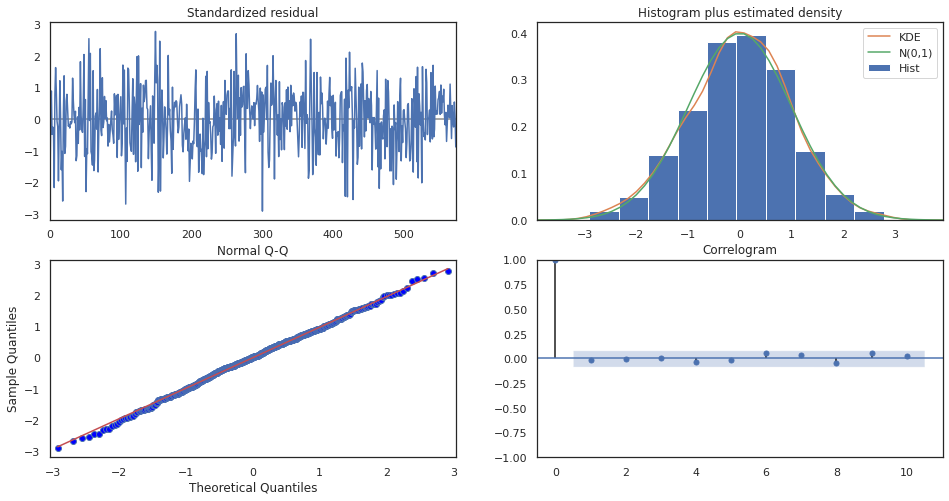

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
# Fit model
model = ARIMA(y_train, order=(2,0,3))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(53)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_mse = mean_squared_error(y_test, y_pred)

print('MSE: {}'.format(score_mse))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


MSE: 4.8681828359613375


In [ ]:
x_train.tail()

569   2018-11-27
570   2018-12-04
571   2018-12-11
572   2018-12-18
573   2018-12-25
Name: date, dtype: datetime64[ns]

In [ ]:
x_test = x_test.to_frame()

In [ ]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 574 to 626
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    53 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 848.0 bytes


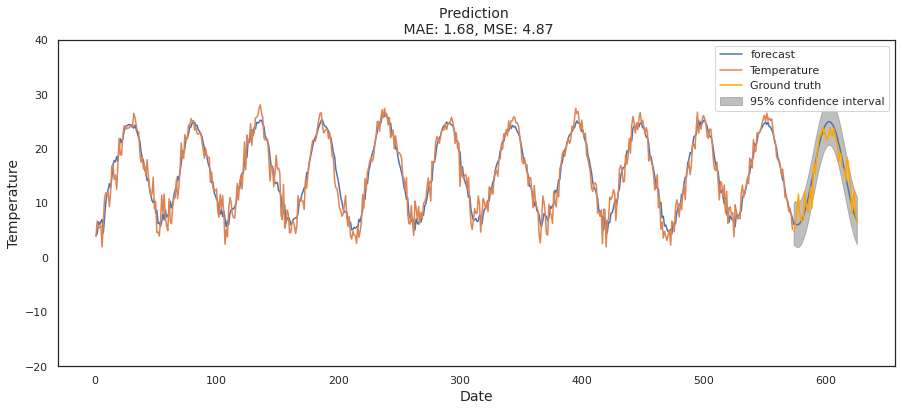

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(start= 1, end=626, ax=ax)
sns.lineplot(x=x_test.index, y=y_test.values, ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, MSE: {score_mse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

ax.set_ylim(-20, 40)
plt.show()

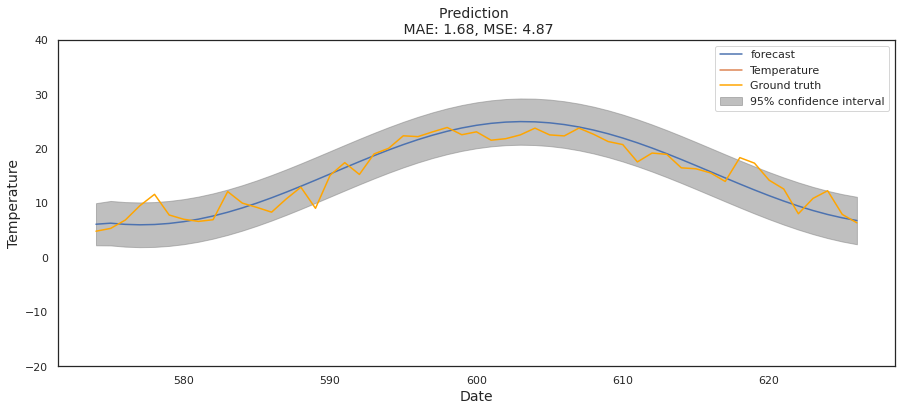

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(start= 574, end=626, ax=ax)
sns.lineplot(x=x_test.index, y=y_test.values, ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, MSE: {score_mse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

ax.set_ylim(-20, 40)
plt.show()

In [ ]:
y_test.head()

574     4.850953
575     5.366905
576     6.898215
577     9.547262
578    11.634703
Name: Temperature, dtype: float64

In [ ]:
x_test = x_test.to_frame()

AttributeError: ignored

In [ ]:
x_test['date'] = x_test['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
x_train

0     2008-01-01
1     2008-01-08
2     2008-01-15
3     2008-01-22
4     2008-01-29
         ...    
569   2018-11-27
570   2018-12-04
571   2018-12-11
572   2018-12-18
573   2018-12-25
Name: date, Length: 574, dtype: datetime64[ns]

###Experimenting on d

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(2,1,3))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(53)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_mse = mean_squared_error(y_test, y_pred)

print('MSE: {}'.format(score_mse))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-para

MSE: 5.3100137872126325


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(2,2,3))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(53)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred)
score_mse = mean_squared_error(y_test, y_pred)

print('MSE: {}'.format(score_mse))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


MSE: 1891.878855192324


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


###Best Model with Seasonality

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2648.267, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3848.457, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2668.956, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3353.477, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4883.685, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2649.216, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2647.811, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3116.883, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2473.425, Time=0.85 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2462.684, Time=1.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2649.081, Time=0.41 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=2649.245, Time=0.77 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2649.776, Time=0.84 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2455.854, Time=0.99 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept

##Experimenting with Prophet

In [ ]:
x_train = x_train.to_frame()
y_train = y_train.to_frame()
x_train = x_train.rename(columns={'date': 'ds'})
y_train = y_train.rename(columns={'Temperature': 'y'})

In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 573
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      574 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.0 KB


In [ ]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 573
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       574 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [ ]:
train_p = pd.merge(x_train, y_train, left_index=True, right_index=True)

In [ ]:
#x_test = x_test.to_frame()
y_test = y_test.to_frame()
x_test = x_test.rename(columns={'date': 'ds'})
y_test = y_test.rename(columns={'Temperature': 'y'})
test_p = pd.merge(x_test, y_test, left_index=True, right_index=True)

In [ ]:
test_p = pd.merge(test_p, test["Temperature_seasonal"], left_index=True, right_index=True)

In [ ]:
test_p.head()

,ds,y,Temperature_seasonal
574,2019-01-01,4.850953,-9.237915
575,2019-01-08,5.366905,-8.478073
576,2019-01-15,6.898215,-8.866193
577,2019-01-22,9.547262,-9.419959
578,2019-01-29,11.634703,-8.115087


In [ ]:
train_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      574 non-null    datetime64[ns]
 1   y       574 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 33.5 KB


In [ ]:
train_size = len(train_p)
test_size = len(test_p)

In [ ]:
from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train_p)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(test_p)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_mse = mean_squared_error(y_test, y_pred.tail(test_size)['yhat'])

print('MSE: {}'.format(score_mse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 4.488601739149083


In [ ]:
#x_test['ds'] = x_test['ds'].apply(lambda x: x.datetime.strptime('%Y-%m-%d'))
x_test['ds']= pd.to_datetime(x_test['ds'])

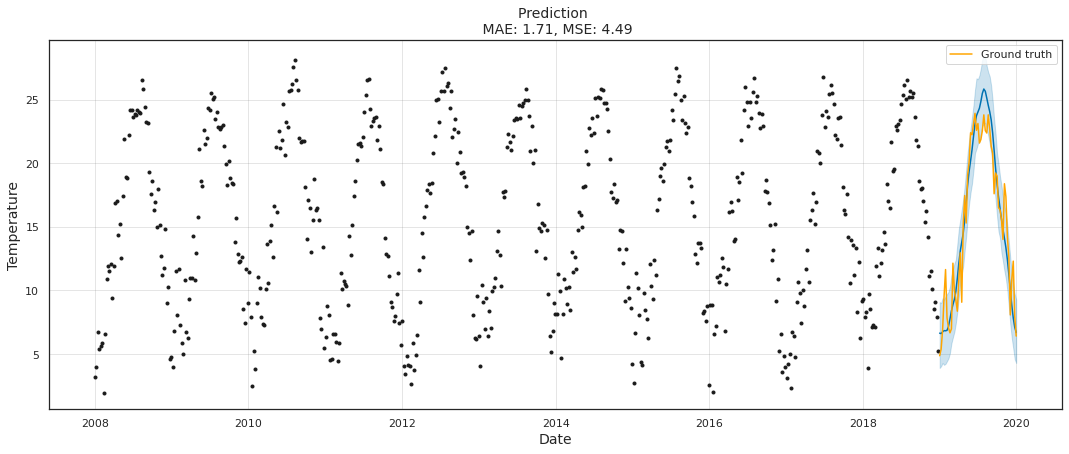

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, MSE: {score_mse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

plt.show()

In [ ]:
train_p.head()

,ds,y
0,2008-01-01,3.197469
1,2008-01-08,3.926786
2,2008-01-15,6.724286
3,2008-01-22,5.357739
4,2008-01-29,5.579822


In [ ]:
train_p = pd.merge(train_p, train["Temperature_seasonal"], left_index=True, right_index=True)

###Temperature Seasonality as Regressor

In [ ]:
# Train the model
model = Prophet()
model.add_regressor('Temperature_seasonal')
model.fit(train_p)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(test_p)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_mse = mean_squared_error(y_test, y_pred.tail(test_size)['yhat'])

print('MSE: {}'.format(score_mse))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE: 4.630456277334131


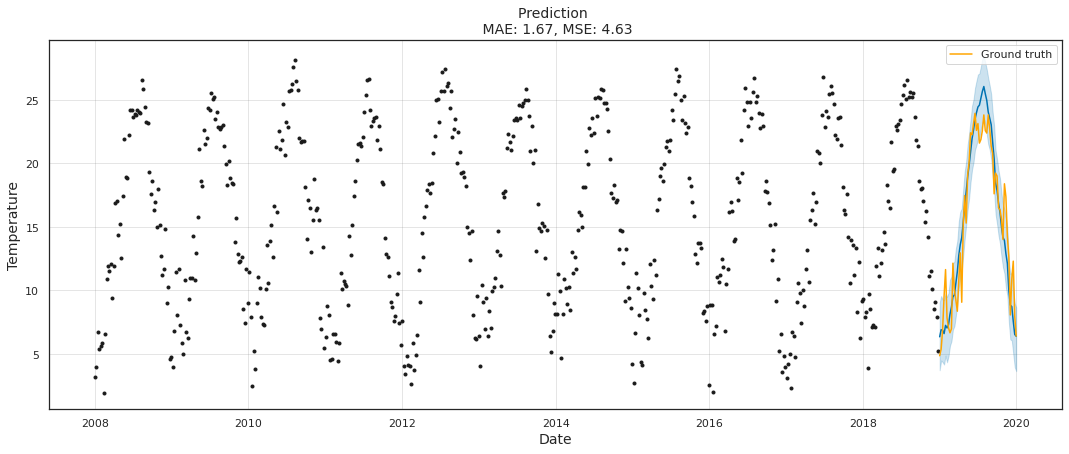

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_test['ds'], y=y_test['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, MSE: {score_mse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Temperature', fontsize=14)

plt.show()

###Add Yearly Seasonality to Prophet

In [ ]:
# Train the model
model = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False)
model.add_seasonality(name = "yearly",period = 52, fourier_order=5)
model.add_regressor('Temperature_seasonal')
model.fit(train_p)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(test_p)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_test, y_pred.tail(test_size)['yhat']))
score_mse = mean_squared_error(y_test, y_pred.tail(test_size)['yhat'])
print('MSE: {}'.format(score_mse))

MSE: 4.763292816050787


In [ ]:
MSE: 4.763292816050787

In [ ]:
# Train the model
model = Prophet()
model.add_regressor('Temperature_seasonal')
model.fit(train_p)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(test_p)

# Calcuate metrics
score_mae = mean_absolute_error(y_test, y_pred.tail(test_size)['yhat'])
score_mse = mean_squared_error(y_test, y_pred.tail(test_size)['yhat'])

print('MSE: {}'.format(score_mse))